In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
from lsst.all_sky_phot.star_catalog import read_simbad
from scipy.stats import iqr, binned_statistic
from scipy.interpolate import interp1d
from lsst.sims.utils import healbin

In [2]:
bsc = read_simbad(isolate_catalog=True, isolate_radius=20.)


In [3]:
data = np.load('L3phot.npz')
phot_tables = data['phot_tables'].copy()
data.close()

In [4]:
# Let's set up an array to hold everything
phot_array = np.zeros((bsc.size, len(phot_tables)), dtype=float)
alt_array = np.zeros((bsc.size, len(phot_tables)), dtype=float)
az_array = np.zeros((bsc.size, len(phot_tables)), dtype=float)
phot_tables[0]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum,annulus_median,aperture_bkg2,aperture_sum_bkgsub2,catalog_indx,az,alt
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
1,2138.186393290717,1406.0974091027192,152254.588799,308767.937069,897.756901866,1924.5,151149.876546,1104.71225279,24,312.627098409,18.8463782045
2,2113.6613028894067,1401.51232326101,149018.713164,301727.023678,1113.30940027,1886.0,148126.093617,892.619547009,25,312.616625297,21.0723546769
3,2105.2638505739965,1397.829477287411,148528.377127,301613.856561,678.447440309,1888.0,148283.173249,245.203877764,26,312.488114059,21.844903237
4,2110.507493442797,1390.7577145637922,148911.97384,302987.359307,388.758492841,1893.5,148715.142239,196.831600333,27,312.011025364,21.4747650644
5,2116.296690921478,1373.1985720982634,149897.743531,305514.179966,135.890605882,1902.0,149382.730678,515.012852363,28,310.912427369,21.1483993542
6,2081.237684708381,1379.312507327185,145790.165038,300566.618762,-1546.41278691,1863.0,146319.677841,-529.512803206,29,311.625326765,24.0634675521
7,2086.538170741269,1375.208023887104,149279.89461,299934.184715,2253.33347512,1872.0,147026.536188,2253.35842211,30,311.317826277,23.6650430621
8,2096.3403499675196,1379.5098331790925,151425.276035,303182.293219,2806.5048497,1884.0,147969.013984,3456.26205127,31,311.480434026,22.8007047551


In [5]:
for i, phot_table in enumerate(phot_tables):
    phot_array[phot_table['catalog_indx'].data, i] = phot_table['aperture_sum_bkgsub2']
    alt_array[phot_table['catalog_indx'].data, i] = phot_table['alt']
    az_array[phot_table['catalog_indx'].data, i] = phot_table['az']

In [6]:
bsc_indx = np.arange(bsc.size)
has_obs = np.where(phot_array.sum(axis=1) > 0)[0]
phot_array = phot_array[has_obs, :]
alt_array = alt_array[has_obs, :]
az_array = az_array[has_obs, :]
bsc_indx = bsc_indx[has_obs]

mag_array = -2.5*np.log10(phot_array)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [7]:
rmss = np.apply_along_axis(iqr, 1, mag_array, scale='normal')

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:4387: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [8]:
rmss
median_mags = np.median(mag_array, axis=1)
real = ~np.isnan(median_mags)
zp = np.median(bsc['Vmag'][bsc_indx][real] - median_mags[real])

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 2494 results
  r = func(a, **kwargs)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


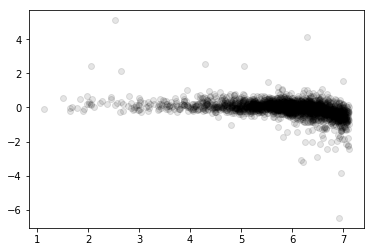

In [9]:
plt.plot(bsc['Vmag'][bsc_indx], median_mags-bsc['Vmag'][bsc_indx]+zp, 'ko', alpha=.1)

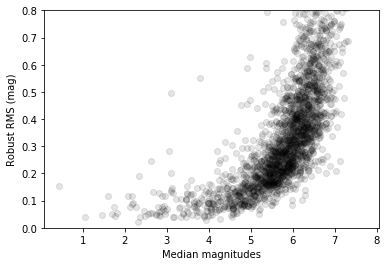

In [10]:
plt.plot(median_mags+zp, rmss, 'ko', alpha=.1)
plt.ylim([0,0.8])
plt.xlabel('Median magnitudes')
plt.ylabel('Robust RMS (mag)')

In [11]:
# OK, now we can make a rolling median to generate an expected rms as a function of mag
bins = np.arange(.5,7.5, .3)
good_vals = np.isfinite(median_mags) & np.isfinite(rmss)
mean_bin, _1, _2 = binned_statistic(median_mags[good_vals]+zp, median_mags[good_vals]+zp, bins=bins)
rms_binned, _1, _2 = binned_statistic(median_mags[good_vals]+zp, rmss[good_vals], statistic=np.median, bins=bins)
rms_interp = interp1d(mean_bin, rms_binned, bounds_error=False)


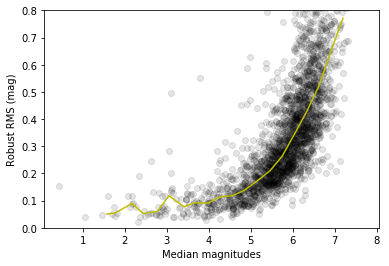

In [12]:
plt.plot(median_mags+zp, rmss, 'ko', alpha=.1)
plt.ylim([0,0.8])
plt.plot(mean_bin, rms_binned, 'y')

plt.xlabel('Median magnitudes')
plt.ylabel('Robust RMS (mag)')

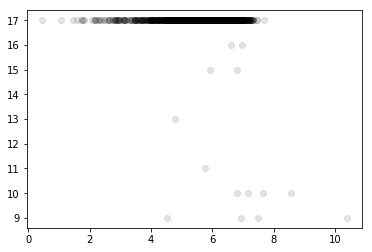

In [13]:
count = mag_array.copy()
count[np.isnan(count)] = 0
count[np.isinf(count)] = 0
count[np.where(count != 0)] = 1
count = count.sum(axis=1)
plt.plot(median_mags+zp, count, 'ko', alpha=.1)

In [14]:
mag_array[:,0].shape

(4735,)

In [15]:
# I should go through each frame and make a transparency map
nside=8
trans_maps = []
sigma_trans_maps = []
err_array = rms_interp(mag_array+zp)
count_maps = []
for i,phot_table in enumerate(phot_tables):
    good_stars = np.isfinite(mag_array[:,i]) & np.isfinite(err_array[:,i]) & np.isfinite(median_mags)
    weights = 1./err_array[good_stars, i]**2
    numerator = healbin(az_array[good_stars, i],
                              alt_array[good_stars, i],
                              (mag_array[good_stars, i]-median_mags[good_stars])*weights, nside, reduceFunc=np.sum)
    denom = healbin(az_array[good_stars, i],
                              alt_array[good_stars, i],
                              weights, nside, reduceFunc=np.sum)
    tmap = numerator/denom
    tmap[np.where((numerator == hp.UNSEEN) | (denom == hp.UNSEEN))] = hp.UNSEEN
    trans_maps.append(tmap)
    count_maps.append(healbin(az_array[good_stars, i],
                              alt_array[good_stars, i],
                              (mag_array[good_stars, i]+zp)*weights, nside, reduceFunc=np.size))
    weights_sum = healbin(az_array[good_stars, i], alt_array[good_stars, i],
                          weights, nside, reduceFunc=np.sum)
    sigma_tmap = 1./np.sqrt(weights_sum)
    sigma_trans_maps.append(sigma_tmap)
    

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


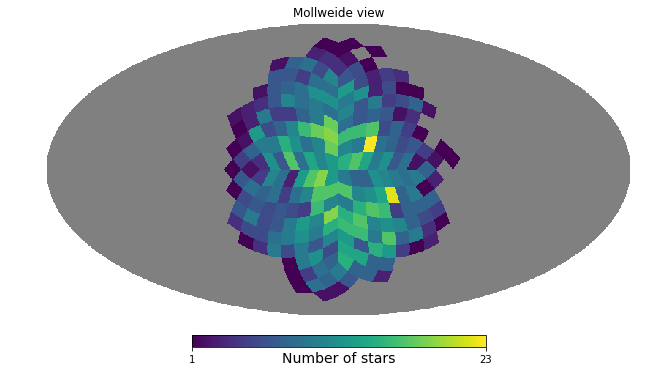

In [16]:
hp.mollview(count_maps[3], rot=(0,90), unit='Number of stars')

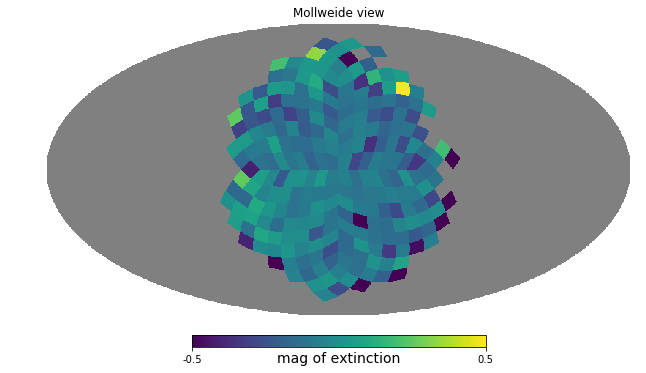

In [17]:
hp.mollview(trans_maps[4], rot=(0,90), min=-0.5, max=0.5, unit='mag of extinction')

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+4/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+4/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+4/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


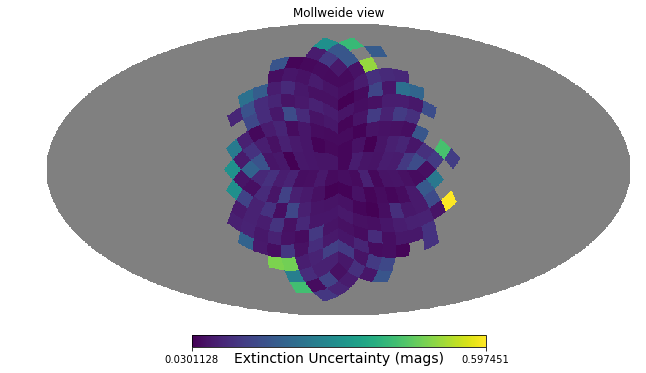

In [18]:
hp.mollview(sigma_trans_maps[1], rot=(0,90), unit='Extinction Uncertainty (mags)')

Thoughts:

It looks like there are still some hot/cold pixels in the sky map that are probably not super real. Not sure what the best way to deal with that is. 

We would want to build a catalog of stars in the camera mag system. Probably ubercal it. That means wanting to run for a year before survey starts since we'll want a full sky catalog. 

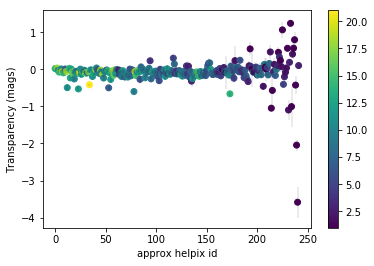

In [21]:
i=1
good = np.where(trans_maps[i] != hp.UNSEEN)
plt.scatter(np.arange(trans_maps[i][good].size), trans_maps[i][good], c=count_maps[i][good])
plt.errorbar(np.arange(trans_maps[i][good].size), trans_maps[i][good], fmt='ko',
             markersize=0, yerr=sigma_trans_maps[4][good], alpha=.1)

cb = plt.colorbar()
plt.xlabel('approx helpix id')
plt.ylabel('Transparency (mags)')